Let's do some GIS with Python!

# The GIS stack in Python 

* geopandas
* shapely
* fiona
* pyproj
* rtree (spatial indexing)
* geoplot (for plotting)

In [1]:
import geopandas as gpd
import pandas as pd
import io
import requests
from shapely.geometry import Point
import matplotlib.pylab as plt
import mplleaflet
import geoplot
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(font_scale=1.5)

In [2]:
%load_ext watermark

In [3]:
%watermark -d -z -v -p geopandas,shapely,fiona,pyproj,geoplot -g -h -m -w

2017-03-22 CET

CPython 3.5.2
IPython 5.3.0

geopandas 0.2.1
shapely 1.5.17.post1
fiona 1.7.4
pyproj 1.9.5.1
geoplot n

compiler   : GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)
system     : Darwin
release    : 16.4.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
host name  : MacBook-Pro-de-Qucit.local
Git hash   : fd48f0ddb567b514c6bf8a0223e377fd6e96d2c8
watermark 1.3.4


# Import Airport data

* Flights data source
* http://openflights.org/data.html

In [3]:
column_names = ['id', 'name', 'city', 'country', 'IATA', 'ICAO', 'latitude', 'longitude', 'altitude', 'timezone', 
                'dst', 'tz_database_time_zone', 'type', 'source']

In [4]:
airports_url="https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"
df = pd.read_csv(airports_url, header=None, names=column_names)

In [5]:
df.head()

,id,name,city,country,IATA,ICAO,latitude,longitude,altitude,timezone,dst,tz_database_time_zone,type,source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


# Transform Pandas DataFrame into a GeoPandas DataFrame

In [6]:
def longitude_latitude_to_geom(row):
    p = Point(row['longitude'], row['latitude'], row['altitude'])
    return p

In [7]:
def add_geometry_column(input_df):
    df = input_df.copy()
    return df.assign(geometry=lambda df: df.apply(longitude_latitude_to_geom, axis=1))

In [8]:
def create_gdf_from_df(input_df):
    df = input_df.copy()
    return (df.pipe(add_geometry_column)
              .drop(['longitude', 'latitude', 'altitude'], axis=1)
              .pipe(gpd.GeoDataFrame))

In [9]:
gdf = df.pipe(create_gdf_from_df)

In [10]:
gdf.head()

,id,name,city,country,IATA,ICAO,timezone,dst,tz_database_time_zone,type,source,geometry
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,10,U,Pacific/Port_Moresby,airport,OurAirports,POINT Z (145.391998291 -6.081689834590001 5282)
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,10,U,Pacific/Port_Moresby,airport,OurAirports,POINT Z (145.789001465 -5.20707988739 20)
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,10,U,Pacific/Port_Moresby,airport,OurAirports,POINT Z (144.2960052490234 -5.826789855957031 ...
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,10,U,Pacific/Port_Moresby,airport,OurAirports,POINT Z (146.725977 -6.569803 239)
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,10,U,Pacific/Port_Moresby,airport,OurAirports,POINT Z (147.2200012207031 -9.443380355834961 ...


# Some analysis

## Cities with the largest number of Airports

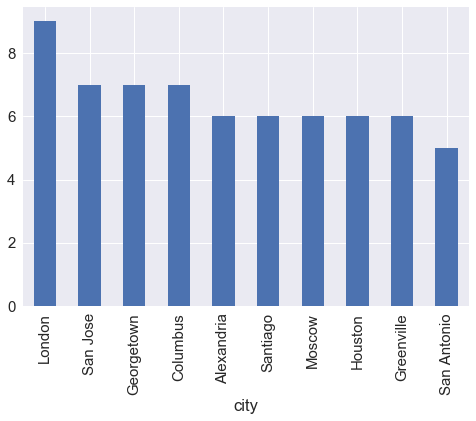

In [11]:
gdf.groupby('city').count()['id'].sort_values(ascending=False).head(10).plot(kind='bar')

## London details

In [12]:
gdf.loc[lambda df: df.city == 'London', :]

,id,name,city,country,IATA,ICAO,timezone,dst,tz_database_time_zone,type,source,geometry
172,174,London Airport,London,Canada,YXU,CYXU,-5,A,America/Toronto,airport,OurAirports,POINT Z (-81.15389999999999 43.035599 912)
487,492,London Luton Airport,London,United Kingdom,LTN,EGGW,0,E,Europe/London,airport,OurAirports,POINT Z (-0.3683330118656158 51.87469863891602...
497,502,London Gatwick Airport,London,United Kingdom,LGW,EGKK,0,E,Europe/London,airport,OurAirports,POINT Z (-0.1902779936790467 51.14810180664063...
498,503,London City Airport,London,United Kingdom,LCY,EGLC,0,E,Europe/London,airport,OurAirports,POINT Z (0.05527799999999999 51.505299 19)
502,507,London Heathrow Airport,London,United Kingdom,LHR,EGLL,0,E,Europe/London,airport,OurAirports,POINT Z (-0.461941 51.4706 83)
542,548,London Stansted Airport,London,United Kingdom,STN,EGSS,0,E,Europe/London,airport,OurAirports,POINT Z (0.234999999404 51.8849983215 348)
5715,7722,London Heliport,London,United Kingdom,\N,EGLW,0,E,Europe/London,airport,OurAirports,POINT Z (-0.179444000125 51.46972274779998 18)
6082,8410,London-Corbin Airport/Magee Field,London,United States,LOZ,KLOZ,-5,A,America/New_York,airport,OurAirports,POINT Z (-84.08489990230001 37.0821990967 1212)
6672,10169,Madison County Airport,London,United States,UYF,KUYF,-5,A,\N,airport,OurAirports,POINT Z (-83.46199799 39.93270111 1082)


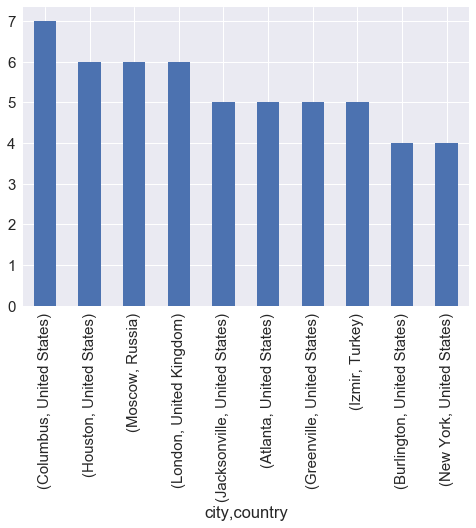

In [13]:
gdf.groupby(['city', 'country']).count()['id'].sort_values(ascending=False).head(10).plot(kind='bar')

## Find airports in France

### Read World shape

In [20]:
DATA_PATH = '/Users/yassinealouini/Downloads/50m_physical/ne_50m_geography_regions_points.shp'

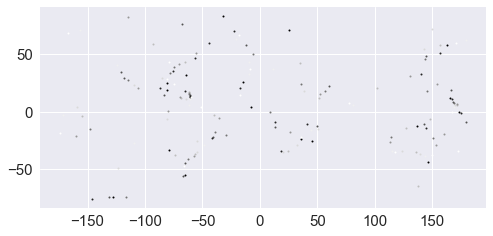

In [22]:
gpd.read_file(DATA_PATH).plot()

# Map of Airports

In [ ]:
ax = gplt.polyplot(continental_usa)
gplt.pointplot(continental_cities, ax=ax)
ax.set_aspect("equal")

In [12]:
fig, ax= plt.subplots(1, 1, figsize=(20, 20))

gdf.head().plot(ax=ax)
mplleaflet.display(fig=fig)

# Import the World layer